# Decision Trees

In this notebook, you will:

 - See the basic formulas of information gain, entropy.
 - Use Pandas to perform one-hot encoding of a dataset
 - Use scikit-learn to implement a Decision Tree, Random Forest and XGBoost models


# Basic Formulas of Entropy and Information Gain

In a decision tree, we decide if a node will be split or not by looking at the **information gain**.

Where,

$$\text{Information Gain} = H(p_1^\text{node})- \left(w^{\text{left}}H\left(p_1^\text{left}\right) + w^{\text{right}}H\left(p_1^\text{right}\right)\right),$$

and $H$ is the entropy, defined as

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

Remember that log here is defined to be in base 2. 

Note that the H attains its higher value when $p = 0.5$. This means that the probability of event is $0.5$. And its minimum value is attained in $p = 0$ and $p = 1$, i.e., the probability of the event happening is totally predictable. Thus, the entropy shows the degree of predictability of an event.

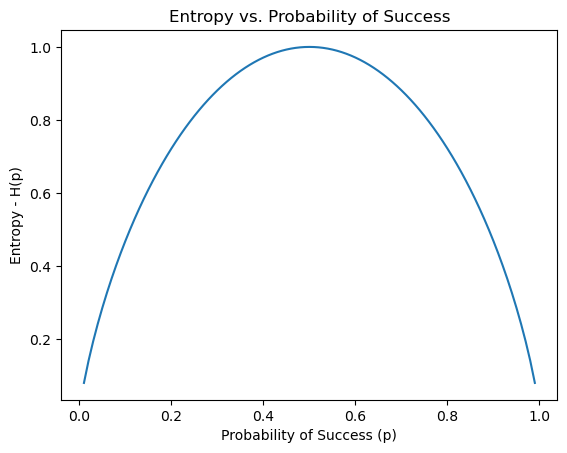

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)

x = np.arange(0.01, 1, 0.01)
y = [entropy(i) for i in x]

plt.plot(x, y)
plt.xlabel('Probability of Success (p)')
plt.ylabel('Entropy - H(p)')
plt.title('Entropy vs. Probability of Success')
plt.show()


In [85]:
# Let's import the basic libraries that we will use

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 1. Introduction

#### Dataset
- This dataset is obtained from Kaggle: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

#### Context
- Cardiovascular disease (CVDs) is the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs.
- People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management.  
- This dataset contains 11 features that can be used to predict possible heart disease.
- Let's train a machine learning model to assist with diagnosing this disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As we can see above, the variable:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

are categorical, so we must one-hot encode them.

In [78]:
# Load the dataset using pandas
df = pd.read_csv('dataset.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We must perform some data engineering before working with the models. There are 5 categorical features, so we will use Pandas to one-hot code them.

# 2. One-hot encoding using Pandas 

First we will remove the binary variables, because one-hot encoding would do nothing to them. To achieve this we will just count how many different values there are in each categorical variable and cosider only the variables with 3 or more values.

In [79]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

As a reminder, one-hot encoding aims to transform a categorical variable with `n` outputs into `n` bianry variables.

Pandas has a buit-in methid to one-hot encode variables, it is a function `pd.get_dummies`. There are several arguments to this fucntion, but here we will only use a few. These are:

- data: DataFrame to be used
- prefix: A list with prefixes, so we know which values we are dealing with
- columns: the list of the columns that will be one-hot encoded. 'prefix' and 'column' must have the same length

In [80]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.#
df = pd.get_dummies(data =df,
                   prefix = cat_variables,
                   columns = cat_variables)

In [81]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Let's choose the variables that will be the input features of the model.

- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`. 

In [82]:
features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable

We started with 11 features. Let's see how many feature variables we have after one-hot encoding.

In [83]:
print(len(features))

20


# 3. Splitting the Dataset

In [94]:
RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size=0.8, random_state = RANDOM_STATE)
# We will keep the shuffle = True since our dataset has not any time dependency.

print(f"train samples: {len(X_train)} \ validation samples: {len(X_val)}")
print(f"target proportion: {sum(y_train)/len(y_train):.4f}")

train samples: 734 \ validation samples: 184
target proportion: 0.5518


# 4. Building the Models

## 4.1 Decision Trees